### K-means: Airbud Edition



In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_path = 'Data\\nba_2013.csv'

nba = pd.read_csv(os.path.relpath(data_path))

nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


In [2]:
# Holy shit, this is how you deal with the setwithcopy warning

# Get index for rows
pg_row_index = nba.pos == 'PG'

# use .loc
point_guards = nba.loc[pg_row_index,:]

ppg = point_guards['pts']/point_guards['g']

# use .loc again to add column
point_guards.loc[:,'ppg'] = ppg

point_guards.head()



C:\Users\hshar\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hshar\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,trb,ast,stl,blk,tov,pf,pts,season,season_end,ppg
24,D.J. Augustin,PG,26,TOT,71,9,1939,298,718,0.415,...,130,313,53,3,125,147,930,2013-2014,2013,13.098592
29,Leandro Barbosa,PG,31,PHO,20,0,368,56,131,0.427,...,37,32,7,4,19,30,150,2013-2014,2013,7.500000
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,...,154,303,26,0,125,129,660,2013-2014,2013,8.354430
38,Jerryd Bayless,PG,25,TOT,72,19,1686,248,617,0.402,...,145,194,60,9,82,161,666,2013-2014,2013,9.250000
50,Steve Blake,PG,33,TOT,55,28,1498,133,353,0.377,...,159,307,54,8,102,85,378,2013-2014,2013,6.872727


In [3]:

# create turnover index dropping 0s to avoid divide by zero error
tov_index = point_guards.tov != 0

# filter to index
point_guards = point_guards.loc[tov_index,:]

# Calculate atr
atr = point_guards.ast/point_guards.tov

# add column
point_guards.loc[:,'atr'] = atr


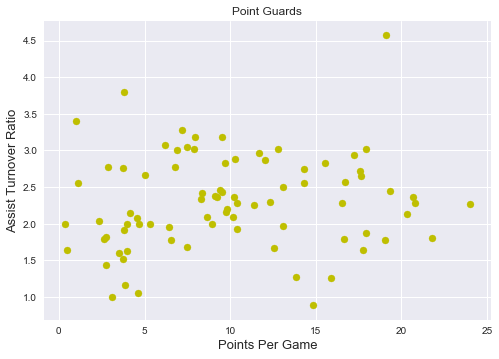

In [4]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [5]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

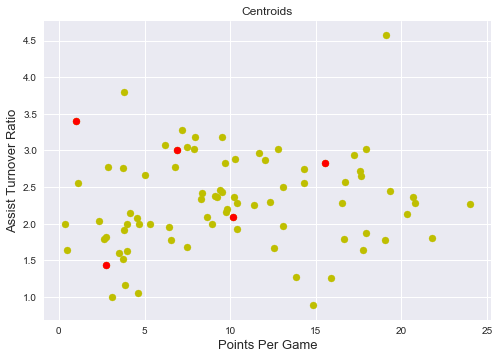

In [6]:
# plot centroids to see where they randomly showed up
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [7]:
"""
Now we can add the centroids to a dictionary to identify unique clusters--
this will allow each centroid to be evaluated iteratively

It also allows us to use centroids that are not just the coordinates of a 
player, so we can locate clusters around arbitrary points.

"""

def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)
import pprint

pprint.pprint(centroids_dict)

{0: [1.0, 3.4],
 1: [2.7450980392156863, 1.4411764705882353],
 2: [15.5125, 2.832558139534884],
 3: [10.146341463414634, 2.094736842105263],
 4: [6.872727272727273, 3.0098039215686274]}


In [8]:
"""
Now to calculate the distance from the players to the centroids
This will allow us to iterate and move centroids to find a compact 
representation of the clusters.

We will use Euclidean distance in this case

N.B. Euclidean distance performs well for 2- or 3- dimensional data, 
for more dimensions it can produce misleading results
"""
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    # calcuate distance between centroid and player_values
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference
        
    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

# test distance calculation
q = [5,2]
p = [3,1]

print(calculate_distance(q,p))

2.23606797749979


In [9]:
"""
Now to create a function that loops through the players and 
finds the centroid closest to each
"""

def assign_to_cluster(row):
    # variable to track closest cluster & distance
    player_coords = [row['ppg'], row['atr']]
    
    centroids_id = []
    distances = []
    
    for centroid_id , centroid in centroids_dict.items():
        centroids_id.append(centroid_id)
        distances.append(calculate_distance(centroid, player_coords))
    # np.amin gives the minimum value from an array    
    return(centroids_id[distances.index(np.amin(distances))])

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis = 1)



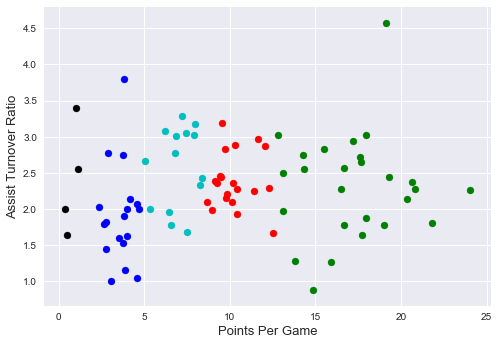

In [10]:
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

In [16]:
# lez recalculate dem centroids
# recall num_clusters is defined above


def recalculate_centroids(dframe):
    new_centroid_dict = dict()
    
    for cluster in range(0, num_clusters):
        rows = dframe[dframe['cluster'] == cluster]
        
        new_centroid = [np.average(rows['ppg']),np.average(rows['atr'])]
        new_centroid_dict[cluster] = new_centroid
    
    return(new_centroid_dict)

centroids_dict = recalculate_centroids(point_guards)
    

    


In [17]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis = 1)

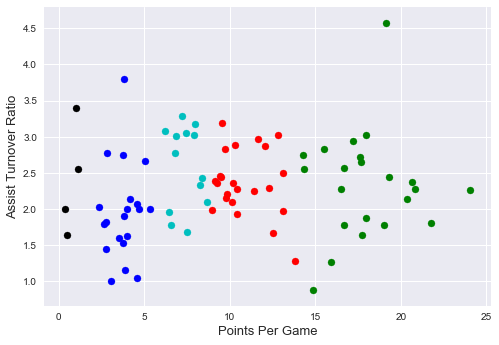

In [18]:
visualize_clusters(point_guards, 5)

### Now for the scikit-learn version

The issue with what we did here was that k-means clustering is highly sensitive to the intial cluster assignments. This is because we can expect there to be small changes from one iteration to the next given the initial centroids. 

Scikit-learn's [KMeans class](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) deals with this by randomly generating several coordinates for the initial centroids and then selecting which of those intial clusters gives us the most compact clusters. This allows it to optimize by selecting from several initial states. 

See the scikit-learn user's guide [article on KMeans](http://scikit-learn.org/stable/modules/clustering.html#k-means) for a good explanation.




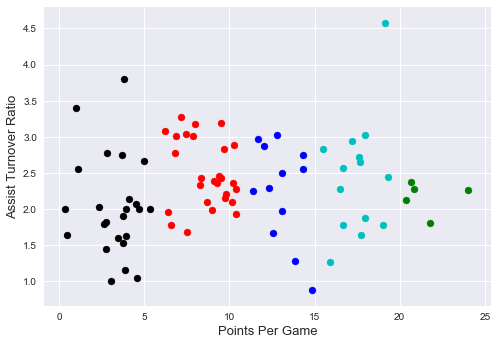

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])

point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)